In [1]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns, Trix
from utilities.bt_analysis import simple_backtest_analysis, get_metrics
from utilities.plot_analysis import plot_bar_by_month, plot_equity_vs_asset, plot_trade_analysis

In [2]:
exchange_name = "binance"
pair = "ETH/USDT"
tf = "2h"
start_date="2020"
end_date="2028-09-10"
type=["long"]

params = {
    "trix_length": 35,
    "trix_signal_length": 7,
    "trix_signal_type": "sma",
    "long_ma_length": 700,
    "long_ma_type": "sma",
}

In [3]:
class Strategy():
    def __init__(
        self,
        df,
        type=["long"],
        params={},
    ):
        self.df = df.copy()
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

    def populate_indicators(self):
        df = self.df
        params = self.params
        df.drop(
            columns=df.columns.difference(['open','high','low','close','volume']), 
            inplace=True
        )

        trix_obj = Trix(close=df["close"], trix_length=params['trix_length'], trix_signal_length=params['trix_signal_length'], trix_signal_type=params['trix_signal_type'])

        df['trix'] = trix_obj.get_trix_pct_line()
        df['trix_signal'] = trix_obj.get_trix_signal_line()
        df['trix_hist'] = df['trix'] - df['trix_signal']

        if params['long_ma_type'] == "ema":
            df["long_ma"] = ta.trend.ema_indicator(df["close"], window=params['long_ma_length'])
        else:
            df["long_ma"] = ta.trend.sma_indicator(df["close"], window=params['long_ma_length'])
        
        self.df = df
        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        params = self.params
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False

        if self.use_long:
            df.loc[
                (df["trix_hist"] > 0) &
                (df['close'] > df["long_ma"])
                , "open_long_market"
            ] = True

            df.loc[
                (df["trix_hist"] < 0)
                , "close_long_market",
            ] = True

        if self.use_short:
            df.loc[
                (df["trix_hist"] < 0) &
                (df['close'] < df["long_ma"])
                , "open_short_market"
            ] = True

            df.loc[
                (df["trix_hist"] > 0)
                , "close_short_market",
            ] = True

        self.df = df   
        return self.df
    
    def run_backtest(self, initial_wallet=1000, start_date=None, end_date=None):
        if start_date:
            self.df = self.df.loc[start_date:]
        if end_date:
            self.df = self.df.loc[:end_date]

        df = self.df
        params = self.params
        wallet = initial_wallet
        maker_fee = 0.0002
        taker_fee = 0.0007
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG --
                    if row["close_long_market"]:
                        if row["close_long_market"]:
                            close_price = row["close"]
                            close_reason = "Market"
                            fee_apply = taker_fee
                        trade_result = (
                            close_price - current_position["price"]
                        ) / current_position["price"]
                        wallet += wallet * trade_result
                        fee = wallet * fee_apply
                        wallet -= fee
                        trades.append(
                            {
                                "open_date": current_position["date"],
                                "close_date": index,
                                "position": "LONG",
                                "open_reason": current_position["reason"],
                                "close_reason": close_reason,
                                "open_price": current_position["price"],
                                "close_price": close_price,
                                "open_fee": current_position["fee"],
                                "close_fee": fee,
                                "open_trade_size": current_position["size"],
                                "close_trade_size": wallet,
                                "wallet": wallet,
                            }
                        )
                        current_position = None

                elif current_position['side'] == "SHORT":                     
                    # -- Close SHORT --
                    if row["close_short_market"]:
                        if row["close_short_market"]:
                            close_price = row["close"]
                            close_reason = "Market"
                            fee_apply = taker_fee
                        trade_result = (
                            current_position["price"] - close_price
                        ) / current_position["price"]
                        wallet += wallet * trade_result
                        fee = wallet * fee_apply
                        wallet -= fee
                        trades.append(
                            {
                                "open_date": current_position["date"],
                                "close_date": index,
                                "position": "SHORT",
                                "open_reason": current_position["reason"],
                                "close_reason": close_reason,
                                "open_price": current_position["price"],
                                "close_price": close_price,
                                "open_fee": current_position["fee"],
                                "close_fee": fee,
                                "open_trade_size": current_position["size"],
                                "close_trade_size": wallet,
                                "wallet": wallet,
                            }
                        )
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                # -- Open short market --
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT",
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days,
            "params": self.params
        }



In [4]:
exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(
    coin=pair, 
    interval=tf
)

strat = Strategy(df=df, type=type, params=params)

strat.populate_indicators()

strat.populate_buy_sell()

bt_result = strat.run_backtest(initial_wallet=1000, start_date=start_date, end_date=end_date)


df_trades, df_days = simple_backtest_analysis(
    trades=bt_result['trades'], 
    days=bt_result['days'],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    indepedant_trade=True
)

Period: [2020-01-11 00:00:00] -> [2024-09-10 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 11633.58 $
Performance: 1063.36 %
Sharpe Ratio: 1.48
Worst Drawdown T|D: -34.7% | -36.49%
Buy and hold performance: 1525.39 %
Performance vs buy and hold: -28.43 %
Total trades on the period: 174
Average Profit: 1.67 %
Global Win rate: 44.25 %

--- Trades Information ---
Mean Trades per day: 0.1
Best trades: +47.93 % the 2021-01-03 06:00:00 -> 2021-01-08 00:00:00
Worst trades: -12.54 % the 2020-05-07 20:00:00 -> 2020-05-10 02:00:00
Total Good trades on the period: 77
Total Bad trades on the period: 97
Average Good Trades result: 7.5 %
Average Bad Trades result: -2.96 %
Mean Good Trades Duration: 4 days 00:10:54.545454545
Mean Bad Trades Duration: 1 days 23:51:20.412371134

--- Days Informations ---
Total: 1705 days recorded
Winning days: 330 days (19.35%)
Neutral days: 1053 days (61.76%)
Loosing days: 322 days (18.89%)
Longest winning streak: 6 days (2020-02-13 00:

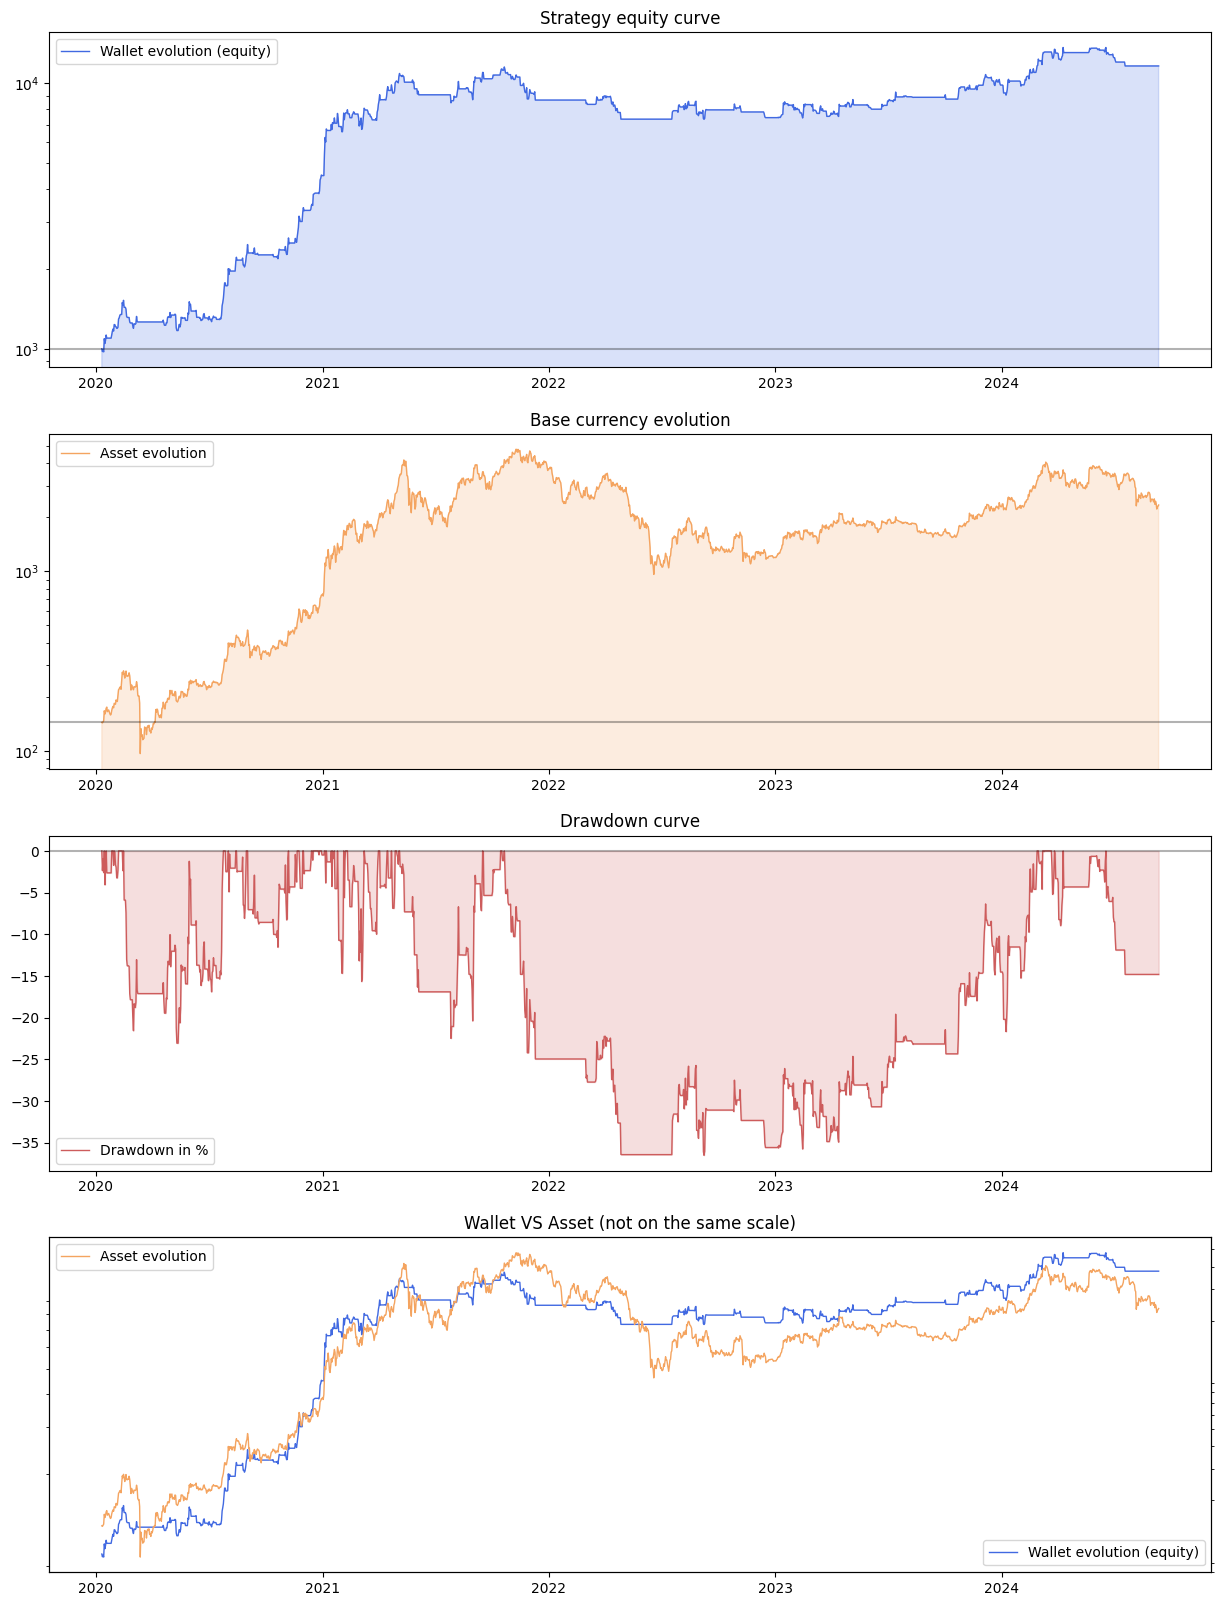

In [5]:
plot_equity_vs_asset(df_days=df_days, log=True)

In [6]:
df_trades.iloc[-20:]

,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,
2024-01-07 02:00:00,2024-01-07 02:00:00,2024-01-08 08:00:00,LONG,Market,Market,2242.20,2211.06,6.441778,6.347867,9196.097968,9062.033354,9062.033354,-140.506392,-0.015279,-0.015749,1 days 06:00:00,11214.043164,2152.009810,0.191903
2024-01-08 12:00:00,2024-01-08 12:00:00,2024-01-13 04:00:00,LONG,Market,Market,2265.47,2554.33,6.343423,7.147238,9055.689931,10203.193424,10203.193424,1141.160070,0.126016,0.100593,4 days 16:00:00,11214.043164,1010.849740,0.090141
2024-01-30 14:00:00,2024-01-30 14:00:00,2024-02-01 04:00:00,LONG,Market,Market,2340.91,2268.80,7.142235,6.917379,10196.051189,9875.051999,9875.051999,-328.141425,-0.032183,-0.034371,1 days 14:00:00,11214.043164,1338.991164,0.119403
2024-02-06 06:00:00,2024-02-06 06:00:00,2024-02-11 16:00:00,LONG,Market,Market,2327.16,2511.16,6.912536,7.453864,9868.139463,10640.923168,10640.923168,765.871169,0.077610,0.067142,5 days 10:00:00,11214.043164,573.119996,0.051107
2024-02-13 00:00:00,2024-02-13 00:00:00,2024-02-16 18:00:00,LONG,Market,Market,2677.61,2762.91,7.448646,7.680556,10633.474522,10964.542095,10964.542095,323.618927,0.030434,0.028669,3 days 18:00:00,11214.043164,249.501069,0.022249
2024-02-19 12:00:00,2024-02-19 12:00:00,2024-02-21 12:00:00,LONG,Market,Market,2894.06,2907.64,7.675179,7.705796,10956.866915,11000.574791,11000.574791,36.032697,0.003289,0.003265,2 days 00:00:00,11214.043164,213.468372,0.019036
2024-02-25 10:00:00,2024-02-25 10:00:00,2024-03-01 06:00:00,LONG,Market,Market,3040.36,3365.41,7.700402,8.517699,10992.874389,12159.623376,12159.623376,1159.048584,0.105436,0.087024,4 days 20:00:00,12159.623376,0.000000,0.000000
2024-03-04 22:00:00,2024-03-04 22:00:00,2024-03-09 02:00:00,LONG,Market,Market,3627.76,3923.21,8.511736,9.198501,12151.111639,13131.517173,13131.517173,971.893798,0.079984,0.068912,4 days 04:00:00,13131.517173,0.000000,0.000000
2024-03-21 00:00:00,2024-03-21 00:00:00,2024-03-28 00:00:00,LONG,Market,Market,3526.05,3496.39,9.192062,9.108361,13122.325111,13002.835966,13002.835966,-128.681207,-0.009806,-0.009995,7 days 00:00:00,13131.517173,128.681207,0.009799


In [7]:
strat.df

,open,high,low,close,volume,trix,trix_signal,trix_hist,long_ma,open_long_market,close_long_market,open_short_market,close_short_market
date,,,,,,,,,,,,,
2020-01-01 00:00:00,129.16,130.65,128.68,130.64,19113.82852,0.058520,0.062116,-0.003596,153.654243,False,True,False,False
2020-01-01 02:00:00,130.63,130.98,129.94,130.20,12571.91056,0.056894,0.061099,-0.004205,153.581329,False,True,False,False
2020-01-01 04:00:00,130.21,130.74,130.11,130.30,7641.51387,0.055218,0.059832,-0.004614,153.510543,False,True,False,False
2020-01-01 06:00:00,130.31,130.75,130.14,130.24,7816.07579,0.053500,0.058374,-0.004874,153.438857,False,True,False,False
2020-01-01 08:00:00,130.24,130.62,129.87,130.17,12349.64993,0.051742,0.056790,-0.005048,153.366743,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-10 02:00:00,2342.84,2347.97,2337.07,2340.84,9198.59620,-0.088643,-0.100102,0.011459,2832.775743,False,False,False,False
2024-09-10 04:00:00,2340.85,2349.94,2328.00,2349.75,11298.55430,-0.084539,-0.096406,0.011867,2831.610529,False,False,False,False
2024-09-10 06:00:00,2349.75,2366.47,2339.58,2363.51,15754.36030,-0.080294,-0.092520,0.012226,2830.449929,False,False,False,False


----- 2020 Cumulative Performances: 349.48% -----


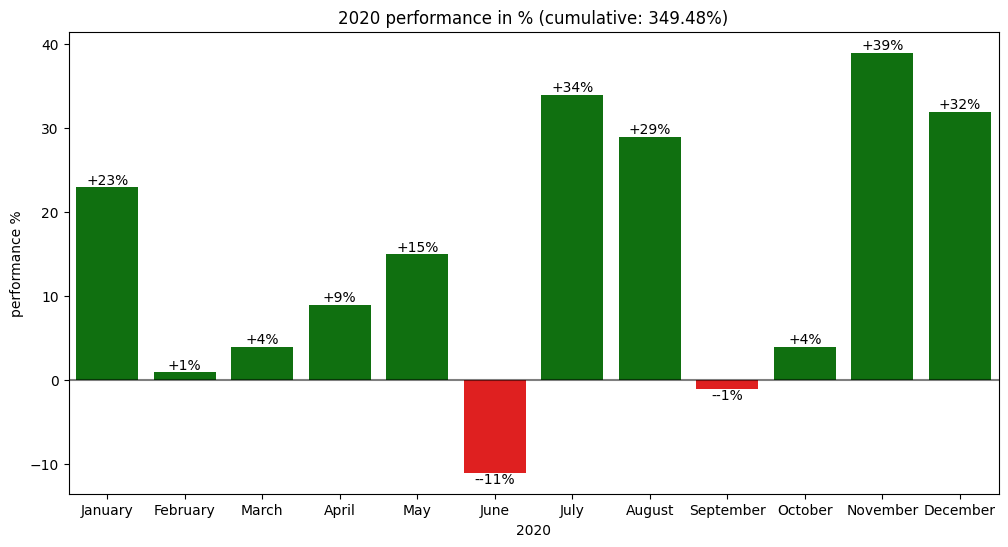

----- 2021 Cumulative Performances: 92.55% -----


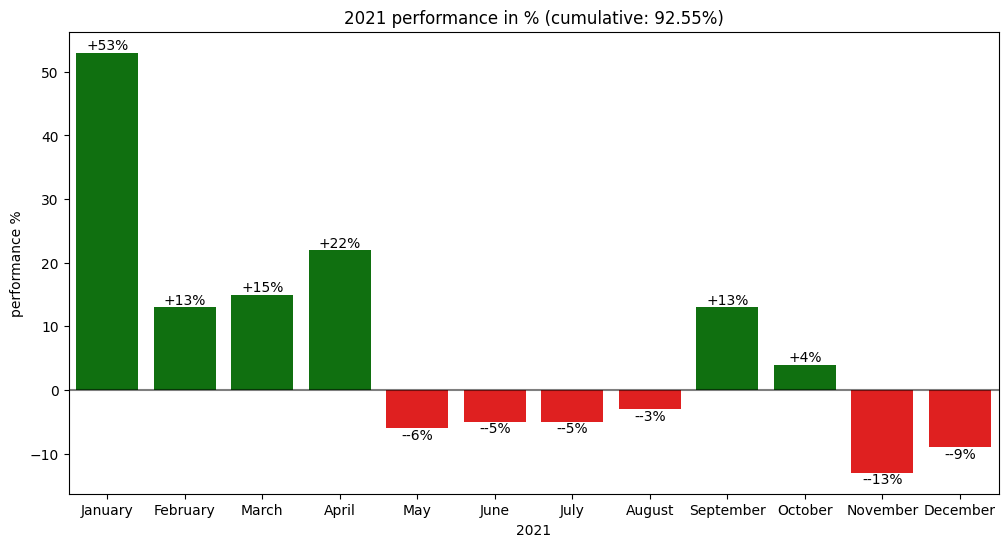

----- 2022 Cumulative Performances: -14.14% -----


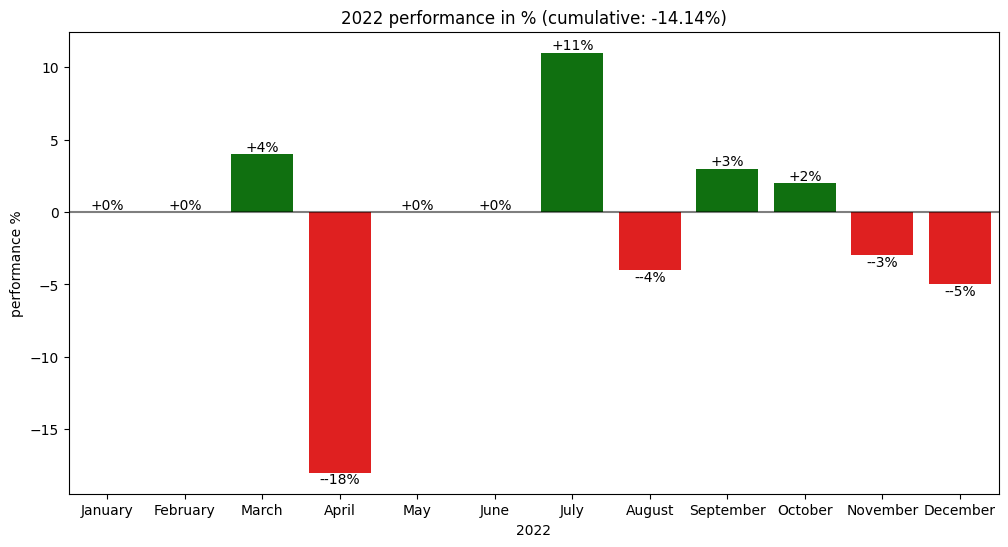

----- 2023 Cumulative Performances: 32.65% -----


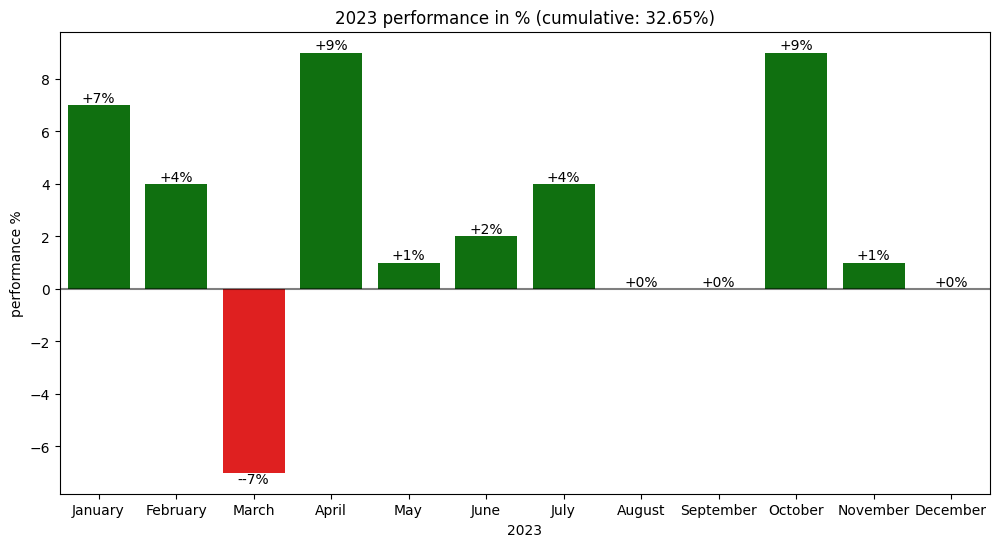

----- 2024 Cumulative Performances: 18.02% -----


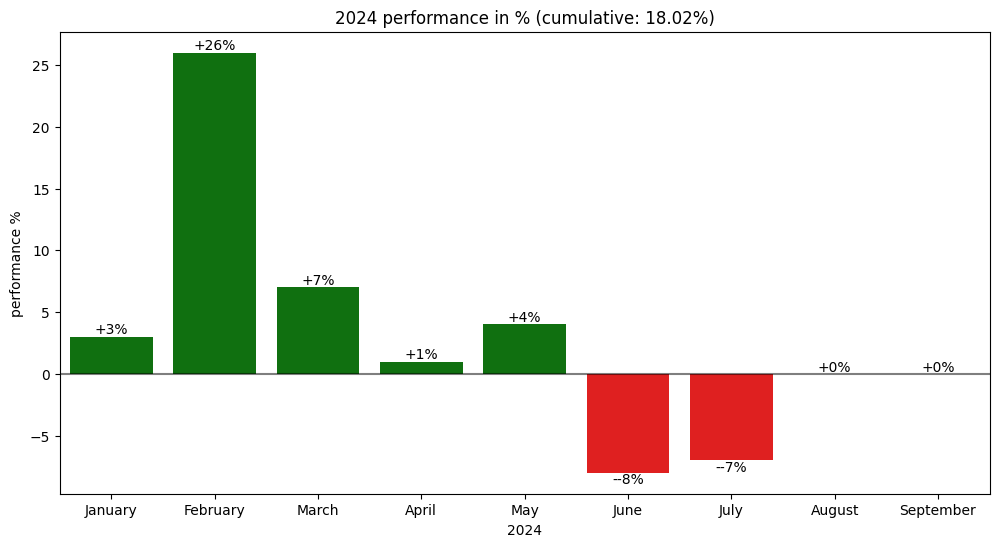

In [8]:
plot_bar_by_month(df_days)